# Detekcija karcinoma dojke

## 1. Analiza

In [1]:
#ucitavamo potrebne biblioteke
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from scipy.stats import norm
from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, precision_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

# podešavanja ispisa
pd.set_option('display.float_format', lambda x: '%.2f' % x) # prikaz df na 2 decimale (npr. za describe)

In [2]:
#ucitavamu bazu u DataFrame
df = pd.read_csv('dataR2.csv')

#proveravamo kako izgleda prvih nekoliko (10) vrsta
df.head(10)

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.50,70,2.71,0.47,8.81,9.70,8.00,417.11,1
1,83,20.69,92,3.12,0.71,8.84,5.43,4.06,468.79,1
2,82,23.12,91,4.50,1.01,17.94,22.43,9.28,554.70,1
3,68,21.37,77,3.23,0.61,9.88,7.17,12.77,928.22,1
4,86,21.11,92,3.55,0.81,6.70,4.82,10.58,773.92,1
5,49,22.85,92,3.23,0.73,6.83,13.68,10.32,530.41,1
6,89,22.70,77,4.69,0.89,6.96,5.59,12.94,1256.08,1
7,76,23.80,118,6.47,1.88,4.31,13.25,5.10,280.69,1
8,73,22.00,97,3.35,0.80,4.47,10.36,6.28,136.85,1
9,75,23.00,83,4.95,1.01,17.13,11.58,7.09,318.30,1


### 1.1 Predobrada podataka

In [3]:
# upoznavanje sa bazom
print(df.shape)

# broj obelezja: 10
# broj uzoraka: 116

# broj obelezja odredjuje dimenzionalnost prostora (praktikum)

print(df.dtypes)
# kategoricka: Classification
# numericka: Age, BMI, Glucose, Insulin, HOMA, Leptin, Adiponectin, Resistin, MCP.1

(116, 10)
Age                 int64
BMI               float64
Glucose             int64
Insulin           float64
HOMA              float64
Leptin            float64
Adiponectin       float64
Resistin          float64
MCP.1             float64
Classification      int64
dtype: object


In [4]:
# proveravamo koliko razlicitih vrenosti imamo kod svih obelezja (float64 ne racunamo iz ociglednih razloga)
print('Age: ', df['Age'].unique())
print('Glucose: ', df['Glucose'].unique())
print('Classification: ', df['Classification'].unique())

# i zakljucujemo da je samo Classification kategoricko obelezje

# iako raspon godina moze biti kategoricko obelezje, same godine nisu to jer bi bi to znacilo da od c razlicitih godina nama
# treba c-1 varijabli da bismo predstavili godine kao kategorije i gubili bismo po jedan stepen slobode za svaku kategoriju
# https://stats.stackexchange.com/questions/413193/is-age-categorical-or-quantitative-or-both

# praktikum kaze da ovim pristupom znacajno povecavamo dimenzionalnost sto nam takodje nije u interesu
# ovaj pristup bi bio formiranje dummy varijabli sto znaci da formiramo toliko novih obelezja koliko ima ralzicitih vrednosti
# u izabranom obelezju
# kod godina to bi znacilo ~50 novih obelezja sto je suludo

Age:  [48 83 82 68 86 49 89 76 73 75 34 29 25 24 38 44 47 61 64 32 36 35 54 45
 50 66 53 28 43 51 67 69 60 77 71 78 85 42 62 59 46 72 55 41 81 65 58 40
 52 74 57]
Glucose:  [ 70  92  91  77 118  97  83  78  82  88  75  86  84  85  95  87  90 106
  80 101  89  79 103  76  94  93 102  60  96 110  74 112  98 116 114 105
 201 100  99 196 199 139 128 134 131 104 108 152 119 138]
Classification:  [1 2]


In [5]:
df.loc[df['Classification']==1,'Classification']= 0
df.loc[df['Classification']==2,'Classification']= 1
df['Classification']=df['Classification'].astype(str).astype(int)
print('y: ', df['Classification'].dtypes)

# pravi problem kod klasifikacije ako nije 0 i 1

y:  int32


In [6]:
print(df.loc[df['Classification']==0,'Classification'].shape) # zdravi
print(df.loc[df['Classification']==1,'Classification'].shape) # bolesni

(52,)
(64,)


In [7]:
df.tail()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
111,45,26.85,92,3.33,0.76,54.68,12.10,10.96,268.23,1
112,62,26.84,100,4.53,1.12,12.45,21.42,7.32,330.16,1
113,65,32.05,97,5.73,1.37,61.48,22.54,10.33,314.05,1
114,72,25.59,82,2.82,0.57,24.96,33.75,3.27,392.46,1
115,86,27.18,138,19.91,6.78,90.28,14.11,4.35,90.09,1


In [8]:
# proveravamo da li postoje nedostajuci podaci
NANs = df.isnull().sum()
print(NANs)
print()
print('Broj NaN uzoraka u celoj bazi:', df.isnull().sum().sum(), 'tj.', df.isnull().sum().sum()/len(df)*100, '%')

Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64

Broj NaN uzoraka u celoj bazi: 0 tj. 0.0 %


### 1.2 Univarijantna analiza obelezja

In [9]:
df.describe()

# raspodela svakog obelezja se moze priblizno predstaviti kroz navedenih 5 brojeva: medijan, min, max, prvi i treci kvartil
# ovde imamo jos i standardnu devijaciju koja je koren varijanse i ukazuje na rasutost podataka
# imamo i 50. percentil

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.00,116.00,116.00,116.00,116.00,116.00,116.00,116.00,116.00,116.00
mean,57.30,27.58,97.79,10.01,2.69,26.62,10.18,14.73,534.65,0.55
std,16.11,5.02,22.53,10.07,3.64,19.18,6.84,12.39,345.91,0.50
min,24.00,18.37,60.00,2.43,0.47,4.31,1.66,3.21,45.84,0.00
25%,45.00,22.97,85.75,4.36,0.92,12.31,5.47,6.88,269.98,0.00
50%,56.00,27.66,92.00,5.92,1.38,20.27,8.35,10.83,471.32,1.00
75%,71.00,31.24,102.00,11.19,2.86,37.38,11.82,17.76,700.09,1.00
max,89.00,38.58,201.00,58.46,25.05,90.28,38.04,82.10,1698.44,1.00


In [10]:
# interkvartilni opseg, gledamo gde se nalazi 50% sredisnjih uzoraka
print('Interkvartilni opseg (IQR) - Age:', np.percentile(df['Age'],75) - np.percentile(df['Age'],25))
print('Interkvartilni opseg (IQR) - BMI:', np.percentile(df['BMI'],75) - np.percentile(df['BMI'],25))
print('Interkvartilni opseg (IQR) - Glucose:', np.percentile(df['Glucose'],75) - np.percentile(df['Glucose'],25))
print('Interkvartilni opseg (IQR) - Insulin:', np.percentile(df['Insulin'],75) - np.percentile(df['Insulin'],25))
print('Interkvartilni opseg (IQR) - HOMA:', np.percentile(df['HOMA'],75) - np.percentile(df['HOMA'],25))
print('Interkvartilni opseg (IQR) - Leptin:', np.percentile(df['Leptin'],75) - np.percentile(df['Leptin'],25))
print('Interkvartilni opseg (IQR) - Adiponectin:', np.percentile(df['Adiponectin'],75) - np.percentile(df['Adiponectin'],25))
print('Interkvartilni opseg (IQR) - Resistin:', np.percentile(df['Resistin'],75) - np.percentile(df['Resistin'],25))
print('Interkvartilni opseg (IQR) - MCP.1:', np.percentile(df['MCP.1'],75) - np.percentile(df['MCP.1'],25))

Interkvartilni opseg (IQR) - Age: 26.0
Interkvartilni opseg (IQR) - BMI: 8.268237355
Interkvartilni opseg (IQR) - Glucose: 16.25
Interkvartilni opseg (IQR) - Insulin: 6.830000000000002
Interkvartilni opseg (IQR) - HOMA: 1.9398211999999997
Interkvartilni opseg (IQR) - Leptin: 25.064625
Interkvartilni opseg (IQR) - Adiponectin: 6.341687500000001
Interkvartilni opseg (IQR) - Resistin: 10.873444999999997
Interkvartilni opseg (IQR) - MCP.1: 430.10675000000003


In [11]:
# koeficijent asimetrije, govori nam kakva je rapodela u pitanju

print('Age:')
print('koef.asimetrije:  %.2f' % skew(df['Age']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Age']))

print()
print('BMI:')
print('koef.asimetrije:  %.2f' % skew(df['BMI']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['BMI']))

print()
print('Glucose')
print('koef.asimetrije:  %.2f' % skew(df['Glucose']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Glucose']))

print()
print('Insulin')
print('koef.asimetrije:  %.2f' % skew(df['Insulin']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Insulin']))

print()
print('HOMA:')
print('koef.asimetrije:  %.2f' % skew(df['HOMA']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['HOMA']))

print()
print('Leptin:')
print('koef.asimetrije:  %.2f' % skew(df['Leptin']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Leptin']))

print()
print('Adiponectin:')
print('koef.asimetrije:  %.2f' % skew(df['Adiponectin']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Adiponectin']))

print('Resistin:')
print('koef.asimetrije:  %.2f' % skew(df['Resistin']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Resistin']))

print()
print('MCP.1:')
print('koef.asimetrije:  %.2f' % skew(df['MCP.1']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['MCP.1']))

Age:
koef.asimetrije:  0.02
koef.spljoštenosti:  -0.99

BMI:
koef.asimetrije:  0.17
koef.spljoštenosti:  -0.93

Glucose
koef.asimetrije:  2.56
koef.spljoštenosti:  8.55

Insulin
koef.asimetrije:  2.54
koef.spljoštenosti:  7.13

HOMA:
koef.asimetrije:  3.76
koef.spljoštenosti:  16.79

Leptin:
koef.asimetrije:  1.29
koef.spljoštenosti:  1.32

Adiponectin:
koef.asimetrije:  1.79
koef.spljoštenosti:  3.71
Resistin:
koef.asimetrije:  2.54
koef.spljoštenosti:  8.48

MCP.1:
koef.asimetrije:  1.41
koef.spljoštenosti:  2.42


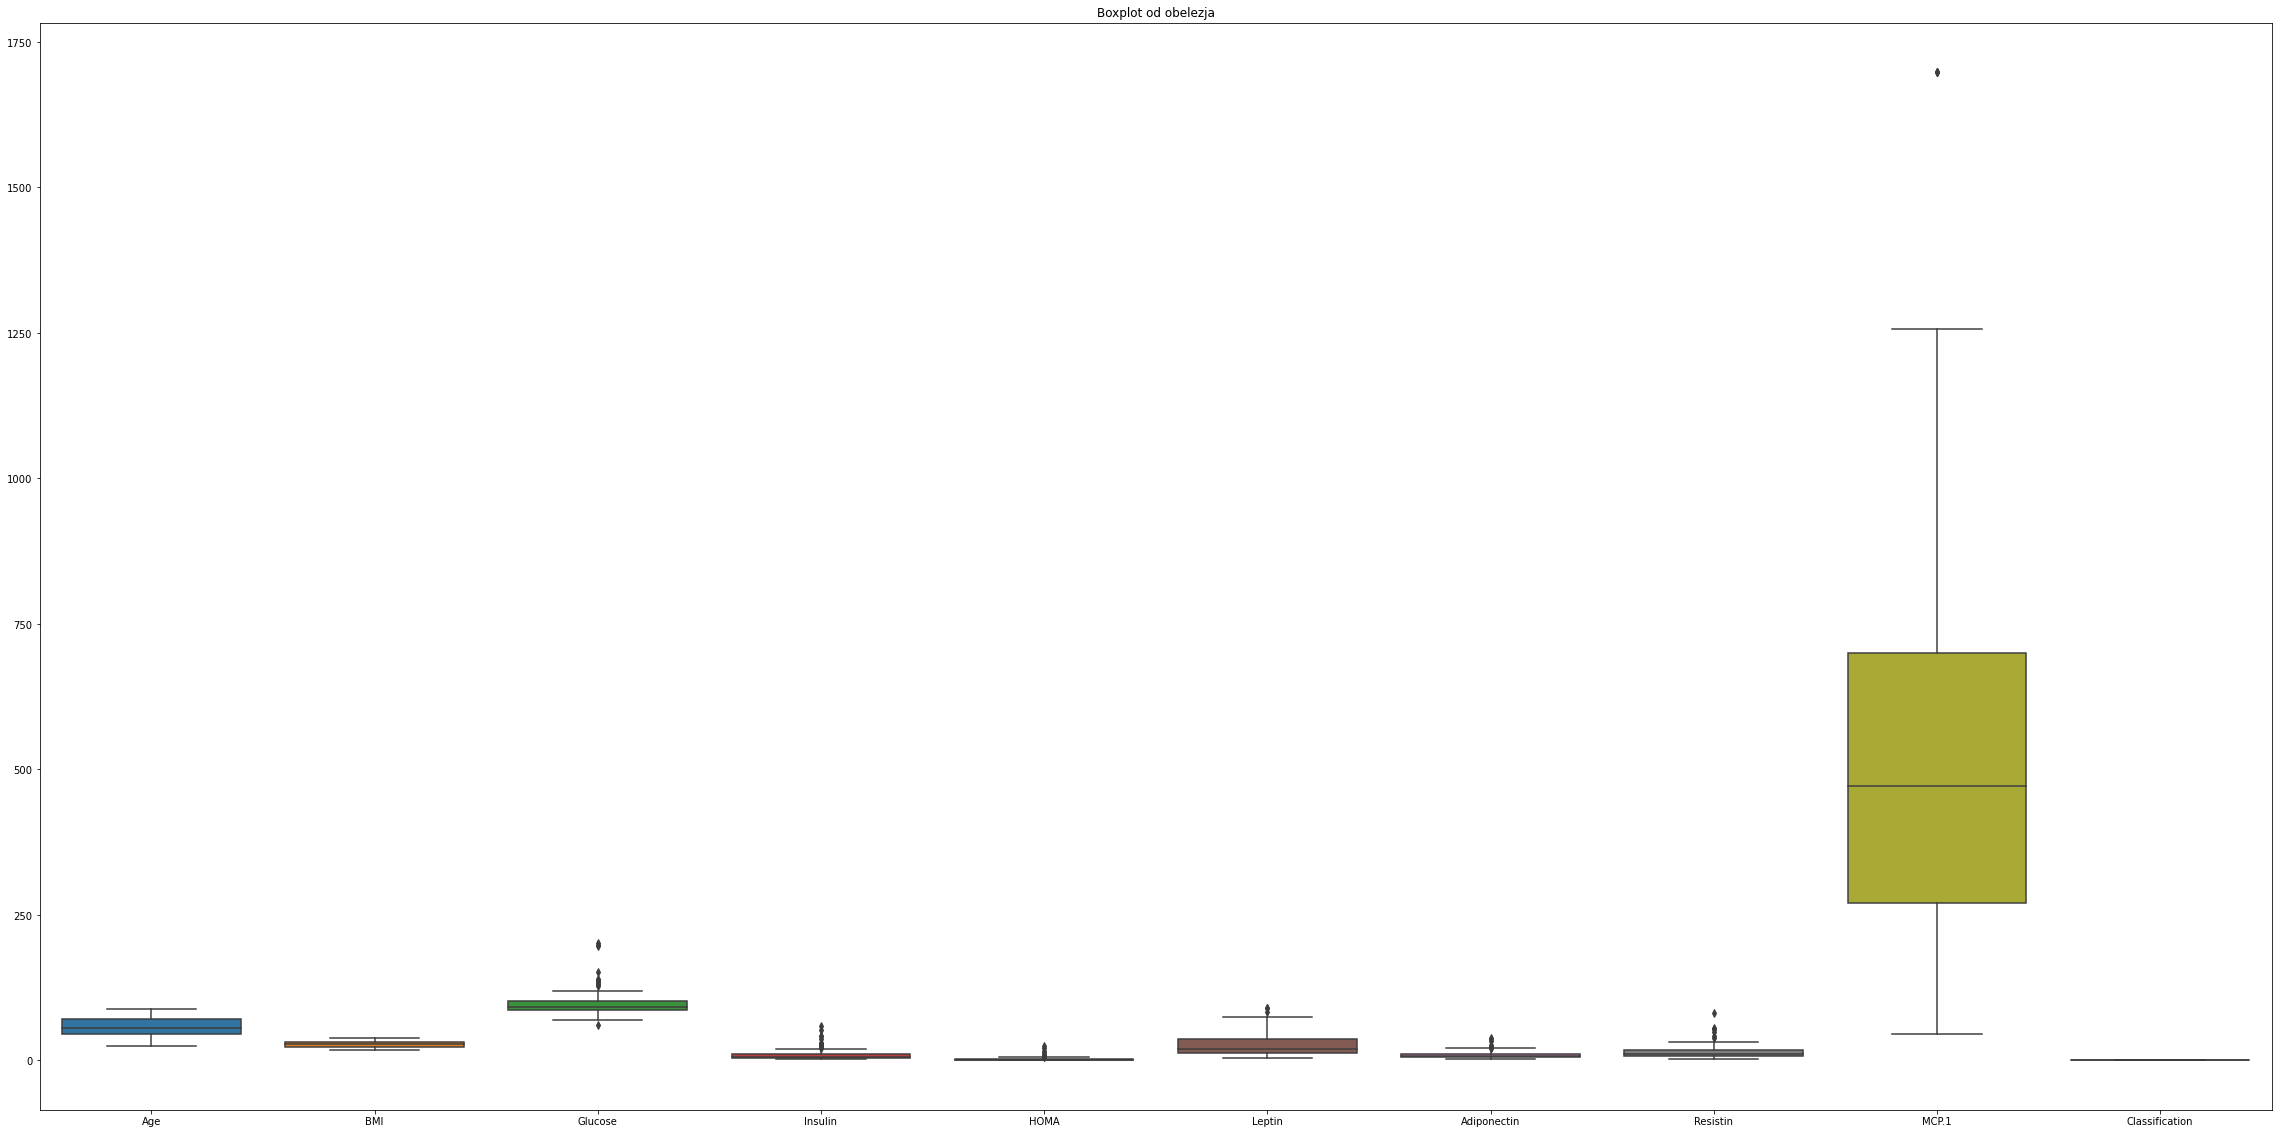

In [12]:
plt.figure(figsize=(40,20))
sb.boxplot(data=df)
plt.title('Boxplot od obelezja')
plt.show()

# odavde se ne vide bas najjasnije vrednosti, tako da cemo ih normalizovati

In [13]:
normalizovan_df = (df-df.min())/(df.max()-df.min())

In [14]:
normalizovan_df.describe()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
count,116.00,116.00,116.00,116.00,116.00,116.00,116.00,116.00,116.00,116.00
mean,0.51,0.46,0.27,0.14,0.09,0.26,0.23,0.15,0.30,0.55
std,0.25,0.25,0.16,0.18,0.15,0.22,0.19,0.16,0.21,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.32,0.23,0.18,0.03,0.02,0.09,0.10,0.05,0.14,0.00
50%,0.49,0.46,0.23,0.06,0.04,0.19,0.18,0.10,0.26,1.00
75%,0.72,0.64,0.30,0.16,0.10,0.38,0.28,0.18,0.40,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [15]:
# cuvamo stari, nenormalizovan df u prvoj varijabli, a normalizovan sad smestamo u df
stari_df = df
df = normalizovan_df

In [16]:
# interkvartilni opseg, gledamo gde se nalazi 50% sredisnjih uzoraka
print('Interkvartilni opseg (IQR) - Age:', np.percentile(df['Age'],75) - np.percentile(df['Age'],25))
print('Interkvartilni opseg (IQR) - BMI:', np.percentile(df['BMI'],75) - np.percentile(df['BMI'],25))
print('Interkvartilni opseg (IQR) - Glucose:', np.percentile(df['Glucose'],75) - np.percentile(df['Glucose'],25))
print('Interkvartilni opseg (IQR) - Insulin:', np.percentile(df['Insulin'],75) - np.percentile(df['Insulin'],25))
print('Interkvartilni opseg (IQR) - HOMA:', np.percentile(df['HOMA'],75) - np.percentile(df['HOMA'],25))
print('Interkvartilni opseg (IQR) - Leptin:', np.percentile(df['Leptin'],75) - np.percentile(df['Leptin'],25))
print('Interkvartilni opseg (IQR) - Adiponectin:', np.percentile(df['Adiponectin'],75) - np.percentile(df['Adiponectin'],25))
print('Interkvartilni opseg (IQR) - Resistin:', np.percentile(df['Resistin'],75) - np.percentile(df['Resistin'],25))
print('Interkvartilni opseg (IQR) - MCP.1:', np.percentile(df['MCP.1'],75) - np.percentile(df['MCP.1'],25))

Interkvartilni opseg (IQR) - Age: 0.39999999999999997
Interkvartilni opseg (IQR) - BMI: 0.4091412809269975
Interkvartilni opseg (IQR) - Glucose: 0.11524822695035461
Interkvartilni opseg (IQR) - Insulin: 0.12190333404726211
Interkvartilni opseg (IQR) - HOMA: 0.07890926538267094
Interkvartilni opseg (IQR) - Leptin: 0.29155422303388434
Interkvartilni opseg (IQR) - Adiponectin: 0.17429889473334145
Interkvartilni opseg (IQR) - Resistin: 0.13783046013436426
Interkvartilni opseg (IQR) - MCP.1: 0.2602611223425917


In [17]:
# koeficijent asimetrije, govori nam kakva je rapodela u pitanju

print('Age:')
print('koef.asimetrije:  %.2f' % skew(df['Age']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Age']))

print()
print('BMI:')
print('koef.asimetrije:  %.2f' % skew(df['BMI']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['BMI']))

print()
print('Glucose')
print('koef.asimetrije:  %.2f' % skew(df['Glucose']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Glucose']))

print()
print('Insulin')
print('koef.asimetrije:  %.2f' % skew(df['Insulin']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Insulin']))

print()
print('HOMA:')
print('koef.asimetrije:  %.2f' % skew(df['HOMA']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['HOMA']))

print()
print('Leptin:')
print('koef.asimetrije:  %.2f' % skew(df['Leptin']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Leptin']))

print()
print('Adiponectin:')
print('koef.asimetrije:  %.2f' % skew(df['Adiponectin']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Adiponectin']))

print('Resistin:')
print('koef.asimetrije:  %.2f' % skew(df['Resistin']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['Resistin']))

print()
print('MCP.1:')
print('koef.asimetrije:  %.2f' % skew(df['MCP.1']))
print('koef.spljoštenosti:  %.2f' % kurtosis(df['MCP.1']))

# nije doslo do promene u koeficijentima asimetricnosti i spljostenosti
# logicno jer smo samo preskalirali

Age:
koef.asimetrije:  0.02
koef.spljoštenosti:  -0.99

BMI:
koef.asimetrije:  0.17
koef.spljoštenosti:  -0.93

Glucose
koef.asimetrije:  2.56
koef.spljoštenosti:  8.55

Insulin
koef.asimetrije:  2.54
koef.spljoštenosti:  7.13

HOMA:
koef.asimetrije:  3.76
koef.spljoštenosti:  16.79

Leptin:
koef.asimetrije:  1.29
koef.spljoštenosti:  1.32

Adiponectin:
koef.asimetrije:  1.79
koef.spljoštenosti:  3.71
Resistin:
koef.asimetrije:  2.54
koef.spljoštenosti:  8.48

MCP.1:
koef.asimetrije:  1.41
koef.spljoštenosti:  2.42


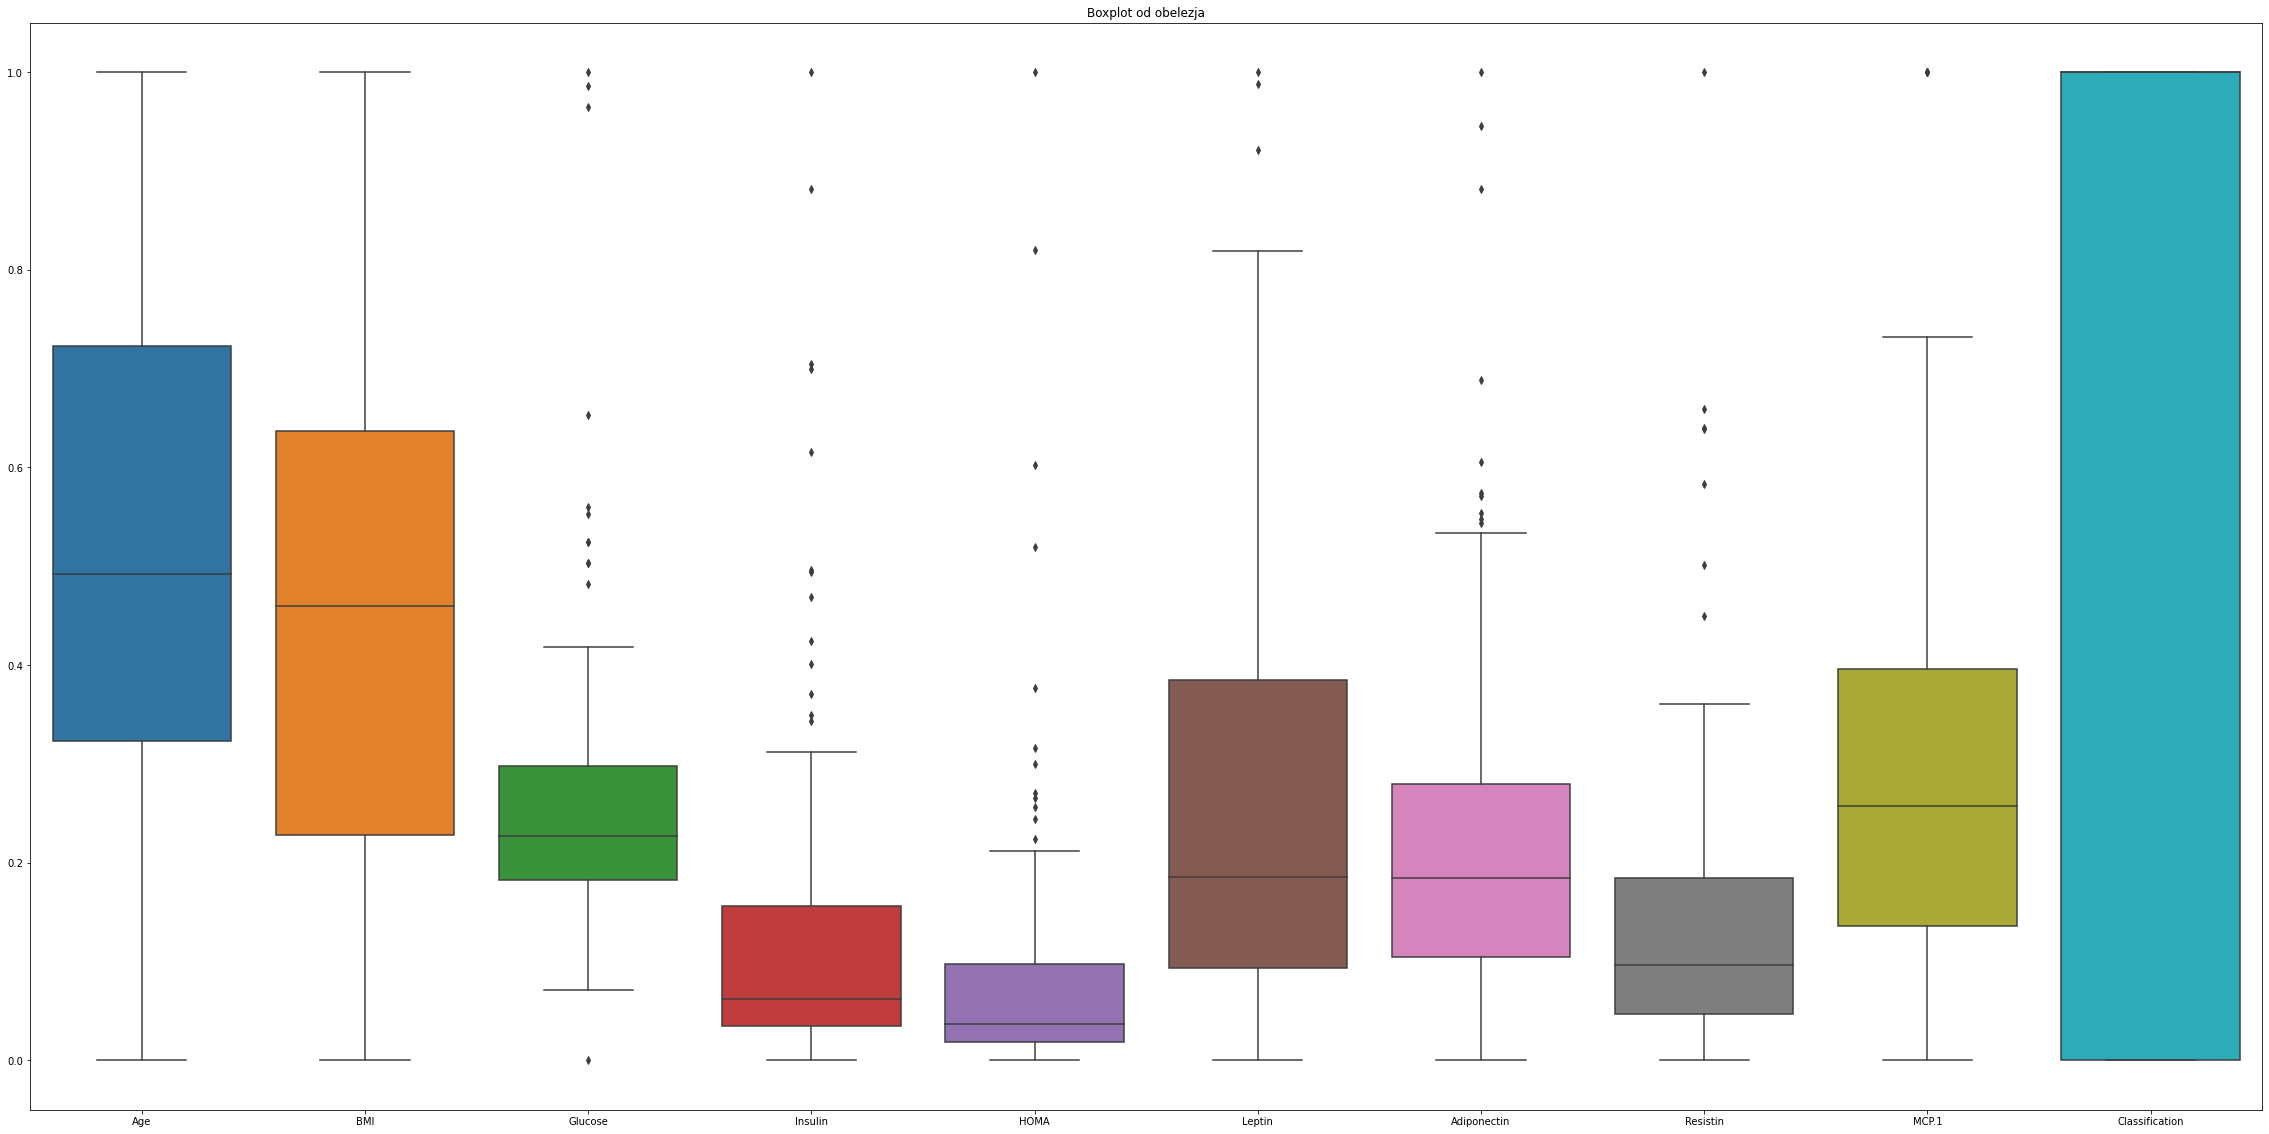

In [18]:
plt.figure(figsize=(40,20))
sb.boxplot(data=normalizovan_df) # df['Glucose'], df['Insulin'], df['HOMA']
plt.title('Boxplot od obelezja')
plt.show()

# vidimo da ima outliera ali posto je baza jako mala ne isplati nam se da ih odbacujemo

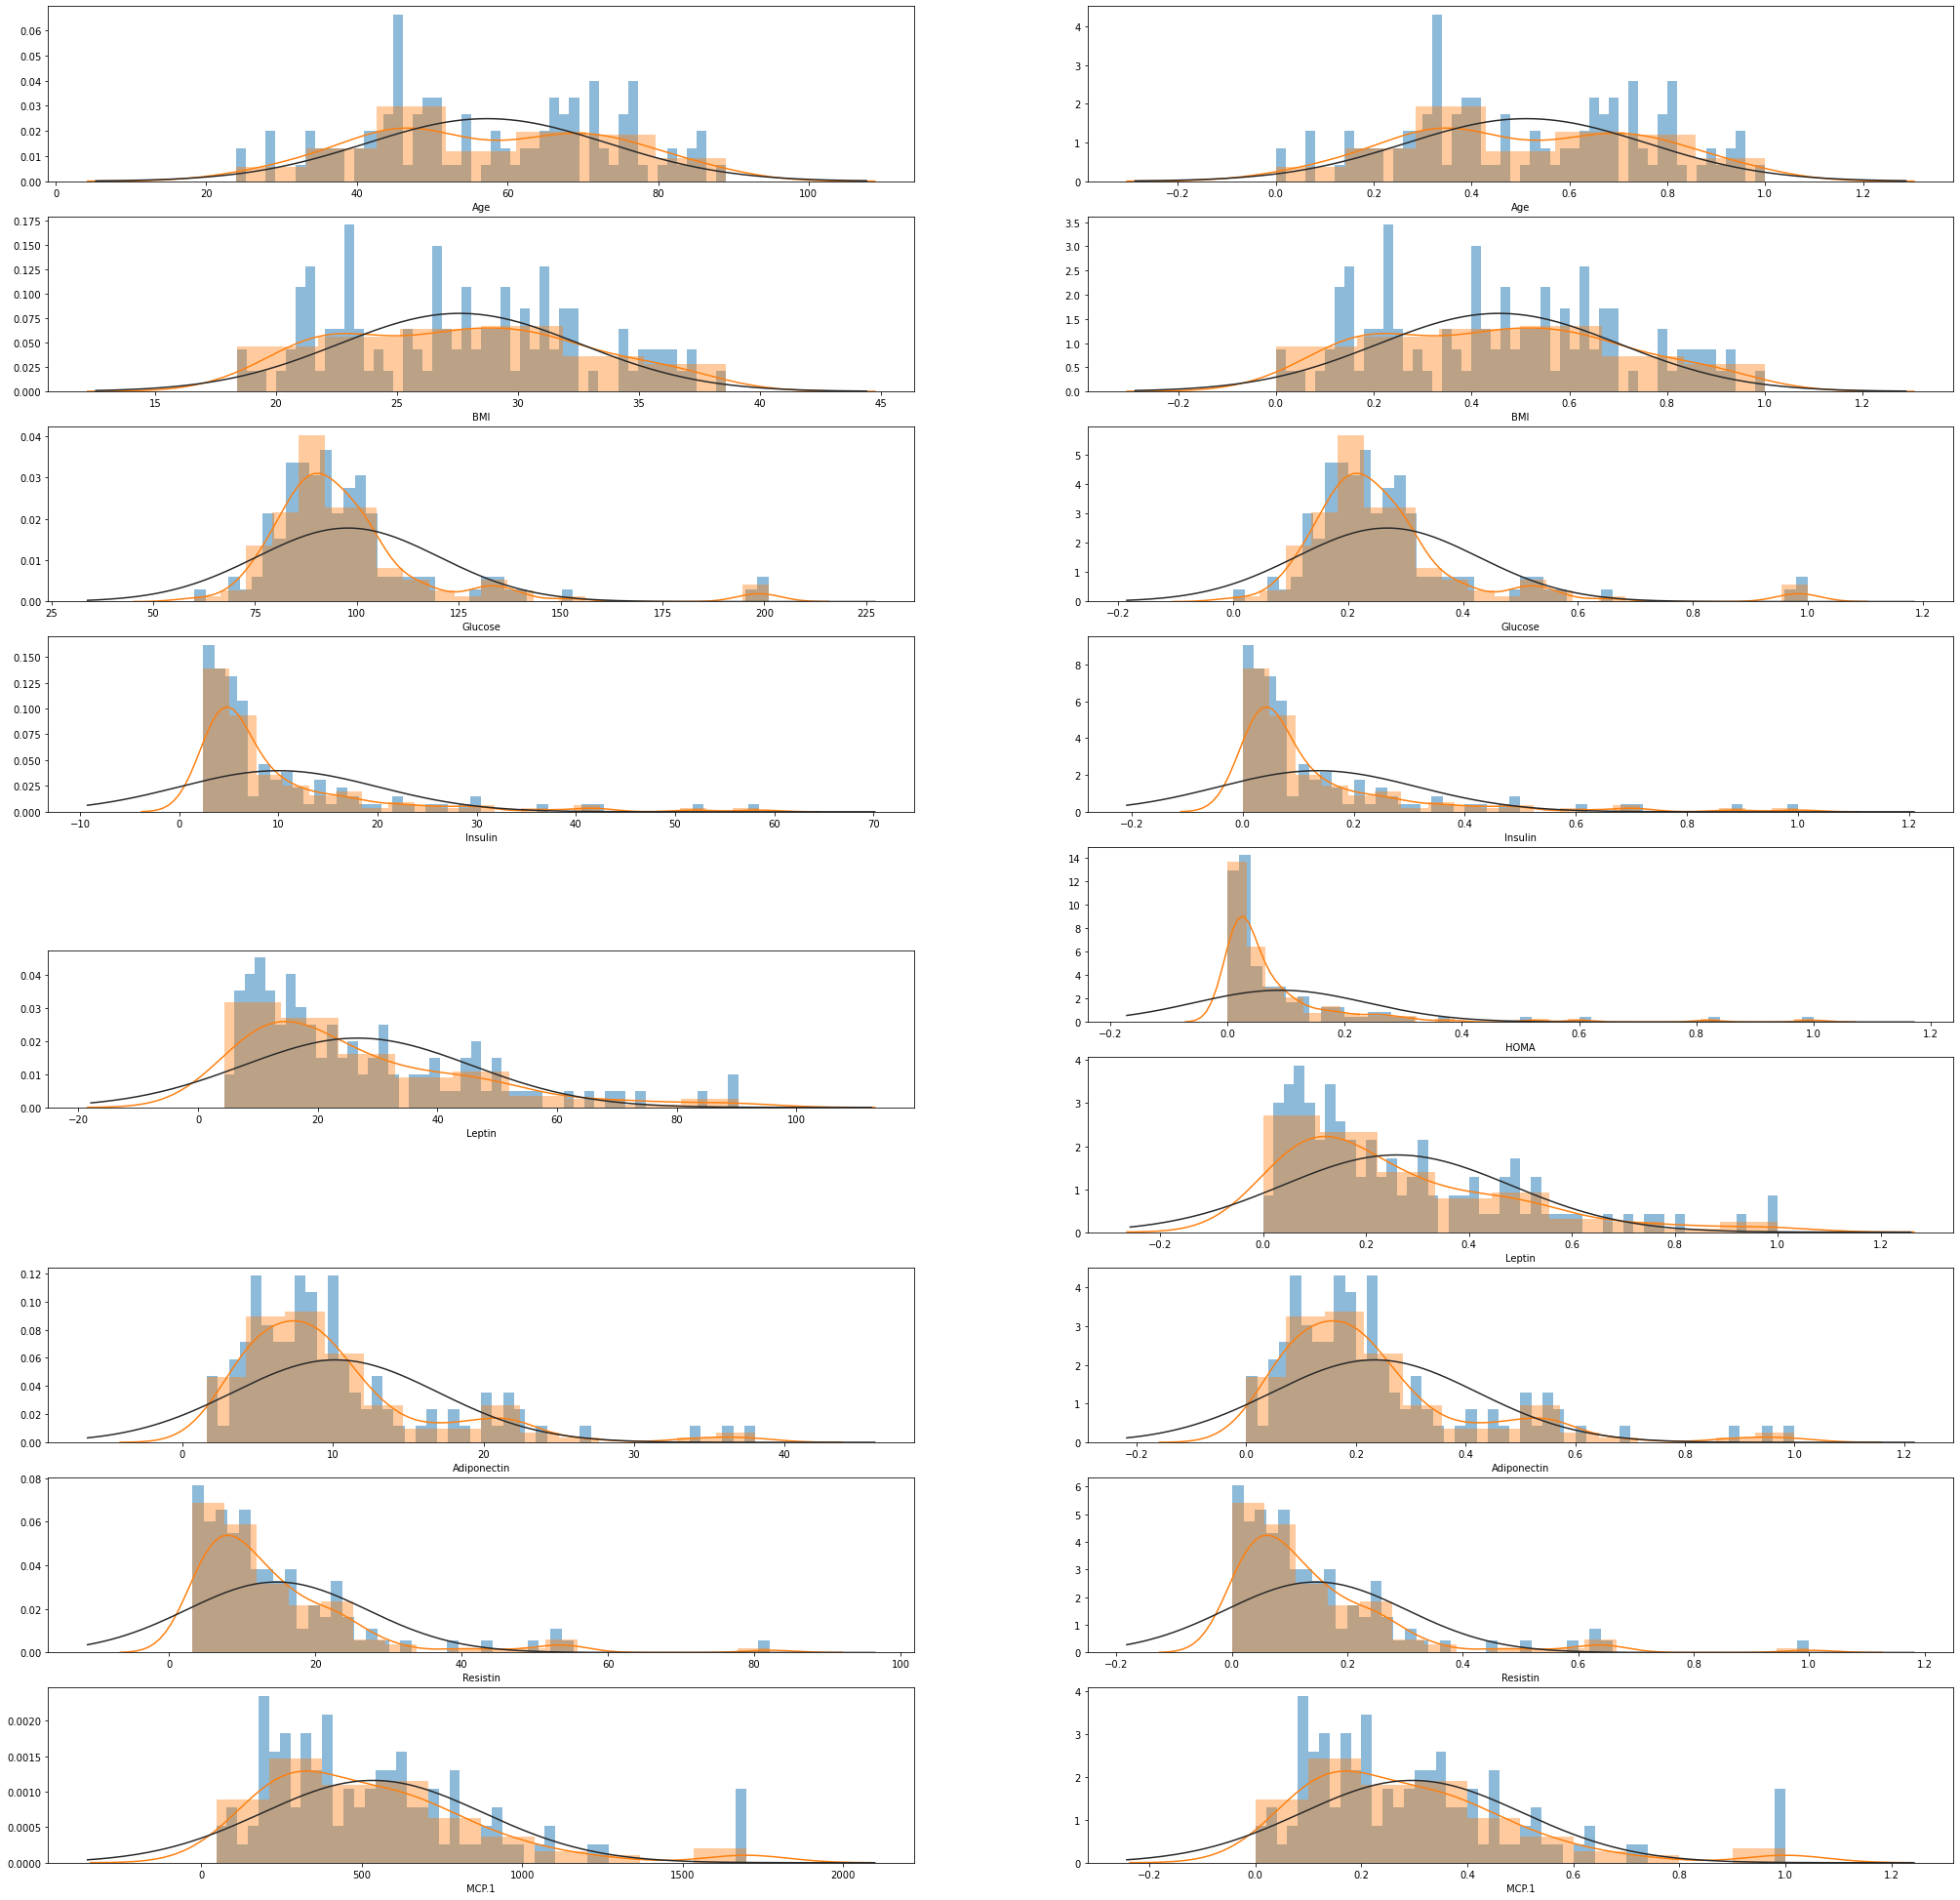

In [19]:
# proveravamo pretpostavke na osnovu koeficijenata spljostenosti i koeficijenata asimetrije
# prva kolona prikazuje vrednosti pre normalizacije, druga posle

plt.figure(figsize=(35,35))

plt.subplot(9,2,1)
plt.hist(stari_df['Age'], bins=50, density=True, alpha=0.5, label='Age')
sb.distplot(stari_df['Age'], fit = norm)

plt.subplot(9,2,2)
plt.hist(df['Age'], bins=50, density=True, alpha=0.5, label='Age')
sb.distplot(df['Age'], fit = norm)

plt.subplot(9,2,3)
plt.hist(stari_df['BMI'], bins=50, density=True, alpha=0.5, label='BMI')
sb.distplot(stari_df['BMI'], fit = norm)

plt.subplot(9,2,4)
plt.hist(df['BMI'], bins=50, density=True, alpha=0.5, label='BMI')
sb.distplot(df['BMI'], fit = norm)

plt.subplot(9,2,5)
plt.hist(stari_df['Glucose'], bins=50, density=True, alpha=0.5, label='Glucose')
sb.distplot(stari_df['Glucose'], fit = norm)

plt.subplot(9,2,6)
plt.hist(df['Glucose'], bins=50, density=True, alpha=0.5, label='Glucose')
sb.distplot(df['Glucose'], fit = norm)

plt.subplot(9,2,7)
plt.hist(stari_df['Insulin'], bins=50, density=True, alpha=0.5, label='Insulin')
sb.distplot(stari_df['Insulin'], fit = norm)

plt.subplot(9,2,8)
plt.hist(df['Insulin'], bins=50, density=True, alpha=0.5, label='Insulin')
sb.distplot(df['Insulin'], fit = norm)

plt.subplot(9,2,9)
plt.hist(stari_df['HOMA'], bins=50, density=True, alpha=0.5, label='HOMA')
sb.distplot(stari_df['HOMA'], fit = norm)

plt.subplot(9,2,10)
plt.hist(df['HOMA'], bins=50, density=True, alpha=0.5, label='HOMA')
sb.distplot(df['HOMA'], fit = norm)

plt.subplot(10,2,11)
plt.hist(stari_df['Leptin'], bins=50, density=True, alpha=0.5, label='Leptin')
sb.distplot(stari_df['Leptin'], fit = norm)

plt.subplot(9,2,12)
plt.hist(df['Leptin'], bins=50, density=True, alpha=0.5, label='Leptin')
sb.distplot(df['Leptin'], fit = norm)

plt.subplot(9,2,13)
plt.hist(stari_df['Adiponectin'], bins=50, density=True, alpha=0.5, label='Adiponectin')
sb.distplot(stari_df['Adiponectin'], fit = norm)

plt.subplot(9,2,14)
plt.hist(df['Adiponectin'], bins=50, density=True, alpha=0.5, label='Adiponectin')
sb.distplot(df['Adiponectin'], fit = norm)

plt.subplot(9,2,15)
plt.hist(stari_df['Resistin'], bins=50, density=True, alpha=0.5, label='Resistin')
sb.distplot(stari_df['Resistin'], fit = norm)

plt.subplot(9,2,16)
plt.hist(df['Resistin'], bins=50, density=True, alpha=0.5, label='Resistin')
sb.distplot(df['Resistin'], fit = norm)

plt.subplot(9,2,17)
plt.hist(stari_df['MCP.1'], bins=50, density=True, alpha=0.5, label='MCP.1')
sb.distplot(stari_df['MCP.1'], fit = norm)

plt.subplot(9,2,18)
plt.hist(df['MCP.1'], bins=50, density=True, alpha=0.5, label='MCP.1')
sb.distplot(df['MCP.1'], fit = norm)

### 1.3 Bivarijantna i multivarijantna analiza obelezja

Text(0, 0.5, 'Insulin')

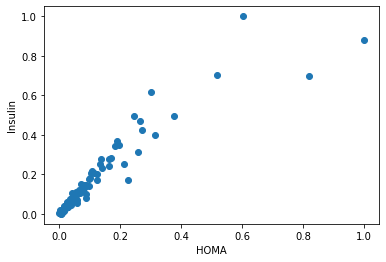

In [20]:
plt.scatter(df['HOMA'], df['Insulin'])
plt.xlabel('HOMA')
plt.ylabel('Insulin')

# korelacija 0.93

Text(0, 0.5, 'Glucose')

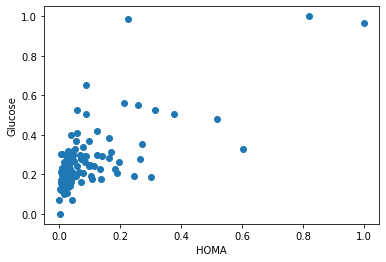

In [21]:
plt.scatter(df['HOMA'], df['Glucose'])
plt.xlabel('HOMA')
plt.ylabel('Glucose')

# korelacija 0.7

Text(0, 0.5, 'Leptin')

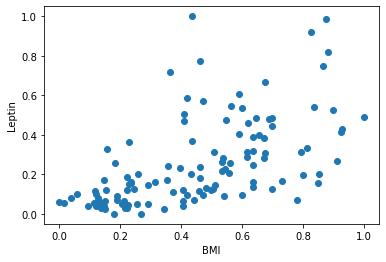

In [22]:
plt.scatter(df['BMI'], df['Leptin'])
plt.xlabel('BMI')
plt.ylabel('Leptin')

# korelacija 0.57

Text(0, 0.5, 'Insulin')

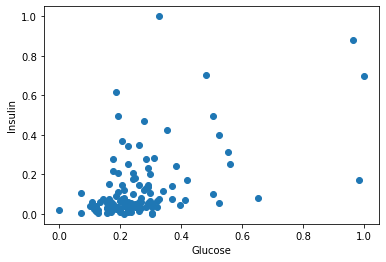

In [23]:
plt.scatter(df['Glucose'], df['Insulin'])
plt.xlabel('Glucose')
plt.ylabel('Insulin')

# korelacija 0.5

Text(0, 0.5, 'BMI')

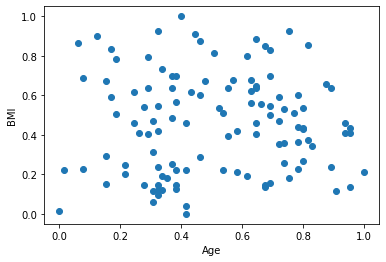

In [24]:
plt.scatter(df['Age'], df['BMI'])
plt.xlabel('Age')
plt.ylabel('BMI')

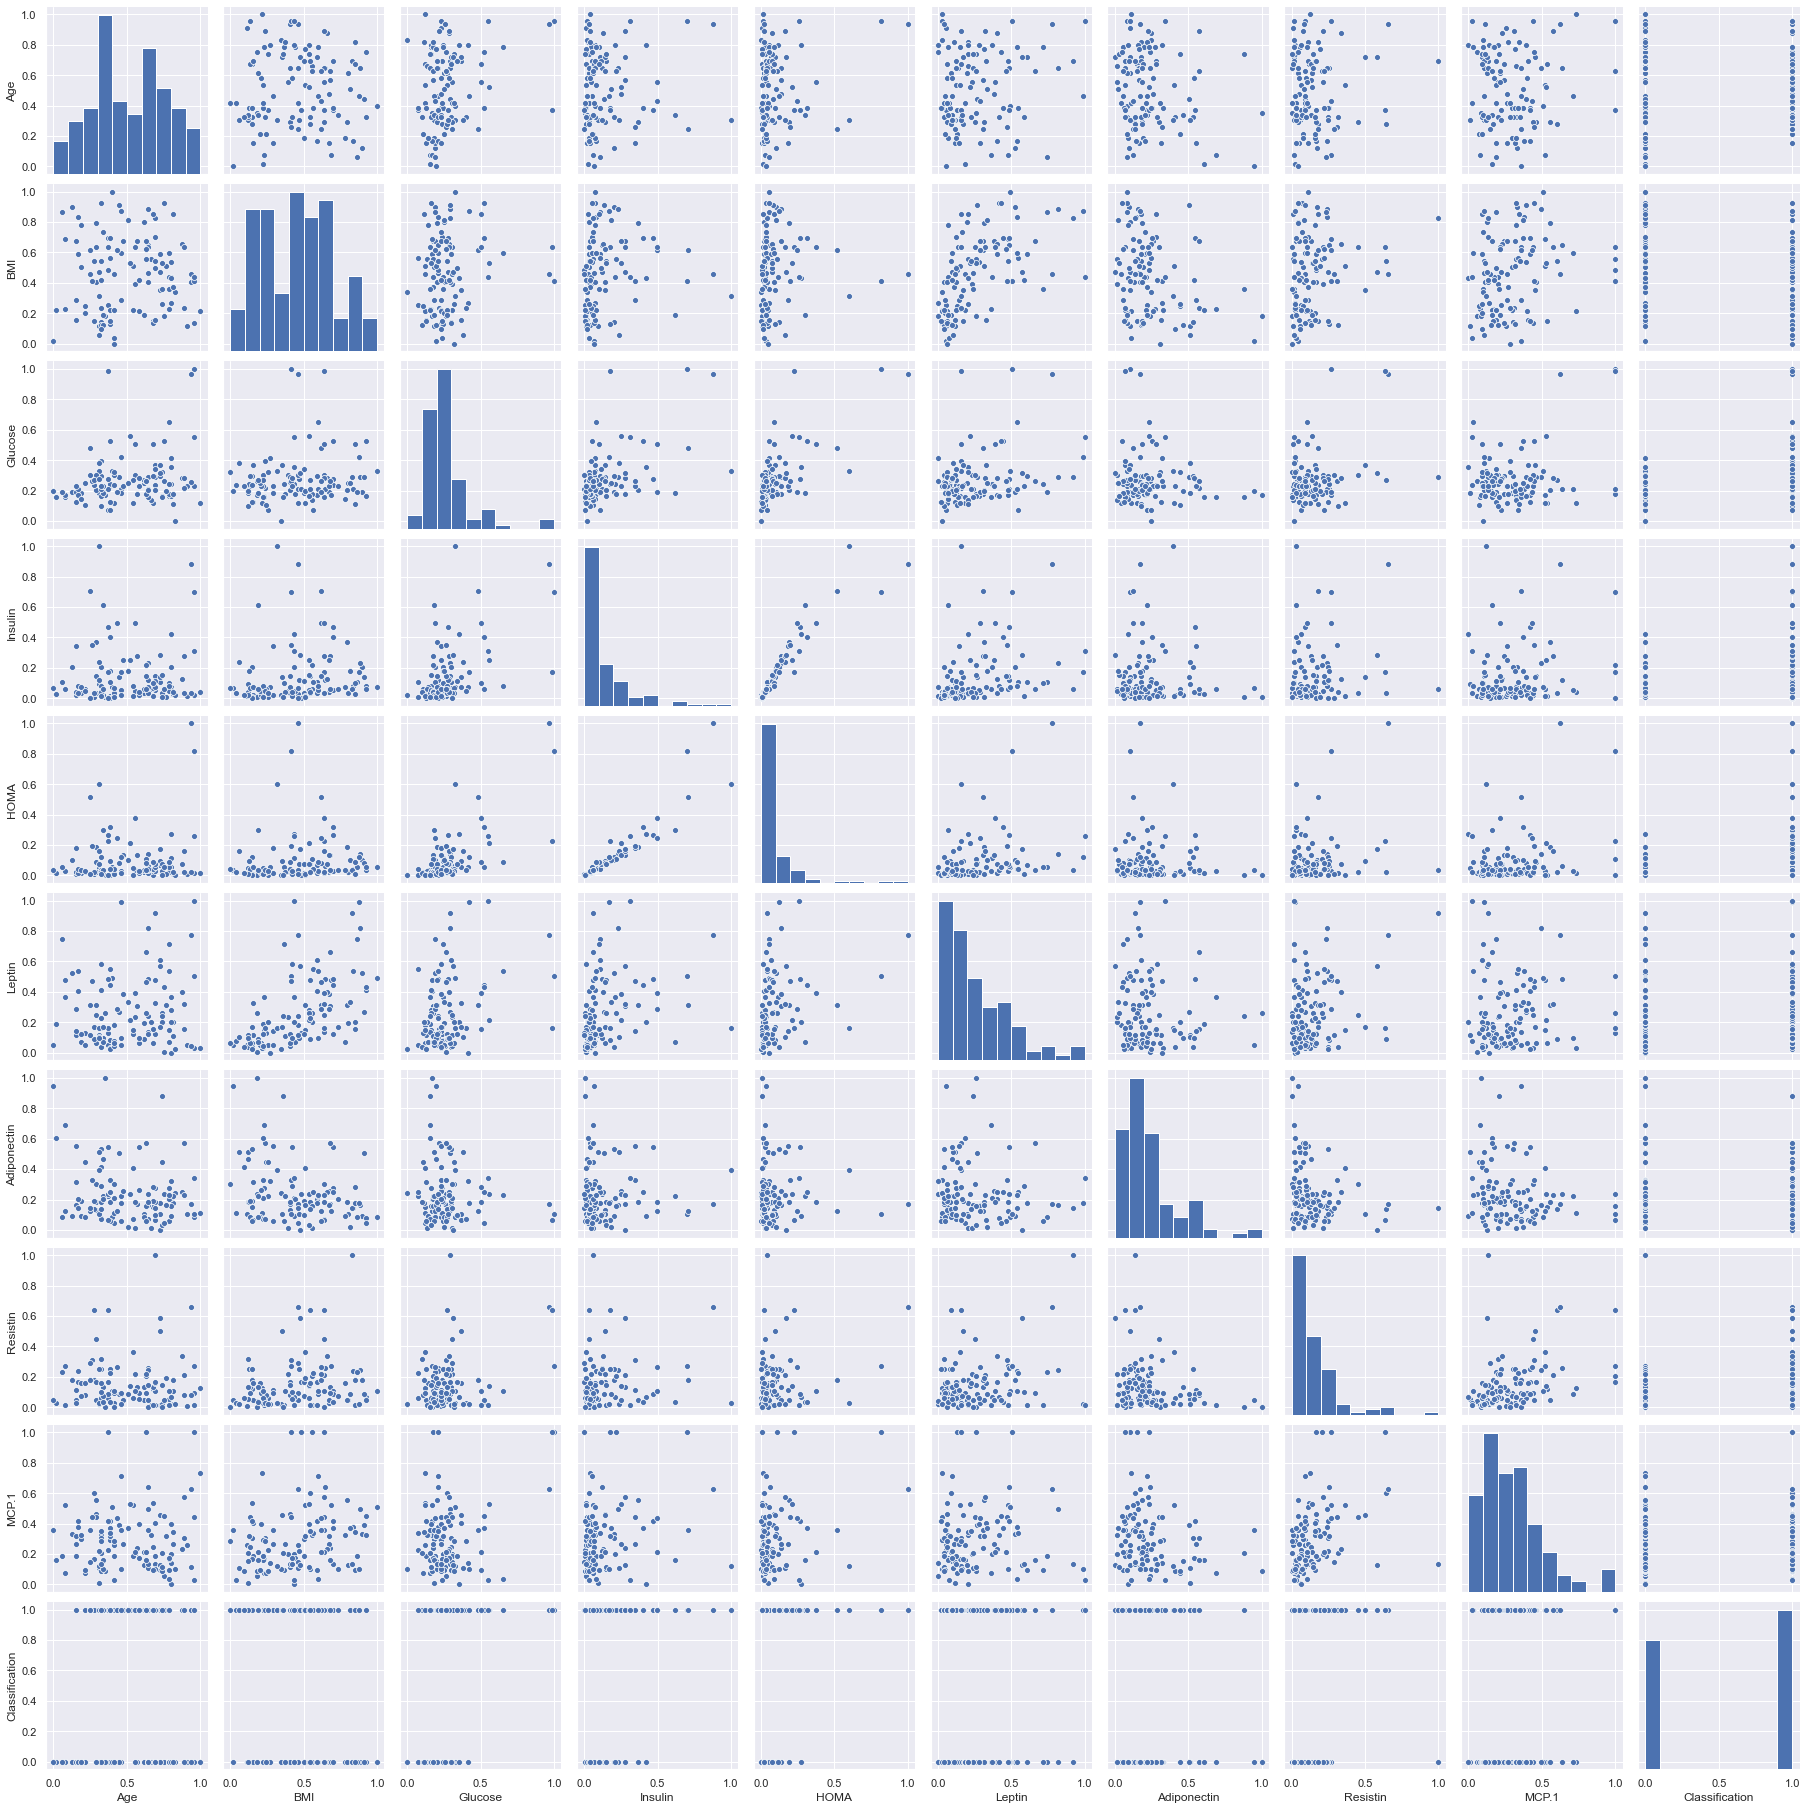

In [25]:
# pairplot za medjusobnu korelaciju svih obelezja

sb.set()
sb.pairplot(df,diag_kws={'bins': 10}, height = 2.5)
plt.show();

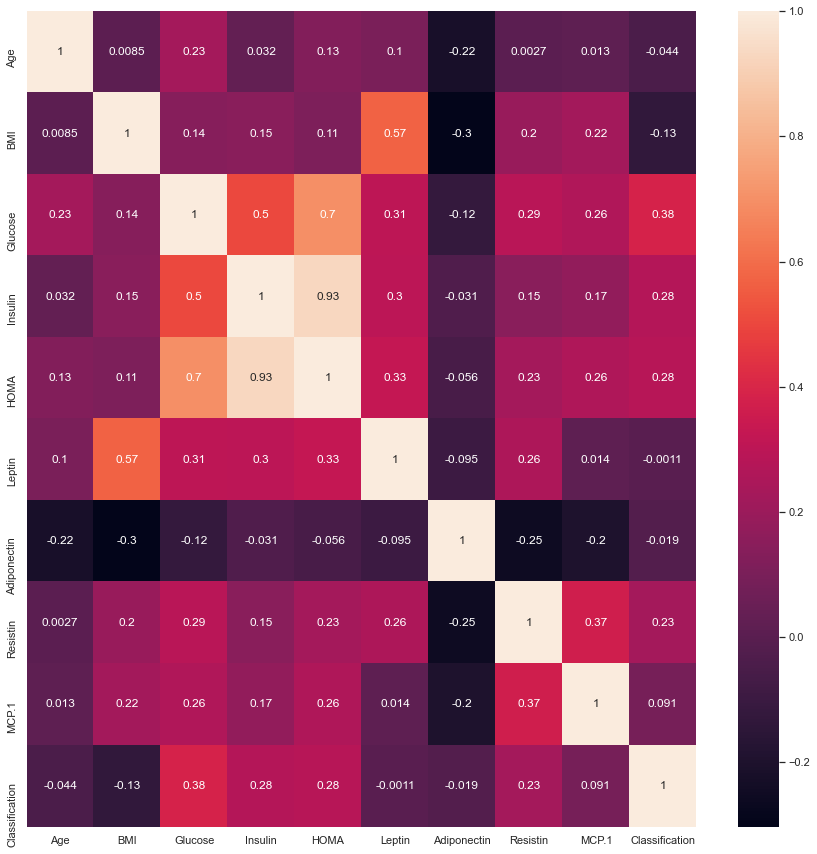

In [26]:
matrica_korelacije = df.corr()
f = plt.figure(figsize=(15, 15))

sb.heatmap(matrica_korelacije, annot=True);

In [27]:
# posto se HOMA racuna na osnovu insulina i glukoze u sustini ne dobijamo novu info te je mozemo izostaviti
stari_df.drop(['HOMA'], inplace = True, axis=1)
df.drop(['HOMA'], inplace = True, axis=1)
print(df.shape)

(116, 9)


In [28]:
bins= [18,25,30,35,40]
labels = ['Normal','Pre-obese','Obesity Class I','Obesity Class II']
stari_df['BMI groups'] = pd.cut(stari_df['BMI'], bins=bins, labels=labels, right=True)

#stari_df.head(50)
#stari_df.tail(50)

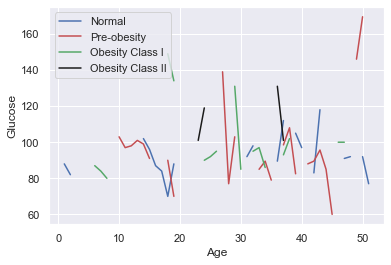

In [29]:
gb = stari_df.groupby(by=['BMI groups', 'Age']).mean()
T_normal = gb.loc['Normal']['Glucose']
T_pre = gb.loc['Pre-obese']['Glucose']
T_oc1 = gb.loc['Obesity Class I']['Glucose']
T_oc2 = gb.loc['Obesity Class II']['Glucose']
plt.plot(np.arange(1, 52, 1), T_normal, 'b', label='Normal') 
plt.plot(np.arange(1, 52, 1), T_pre, 'r', label='Pre-obesity')
plt.plot(np.arange(1, 52, 1), T_oc1, 'g', label='Obesity Class I')
plt.plot(np.arange(1, 52, 1), T_oc2, 'k', label='Obesity Class II')
plt.ylabel('Glucose')
plt.xlabel('Age')
plt.legend()

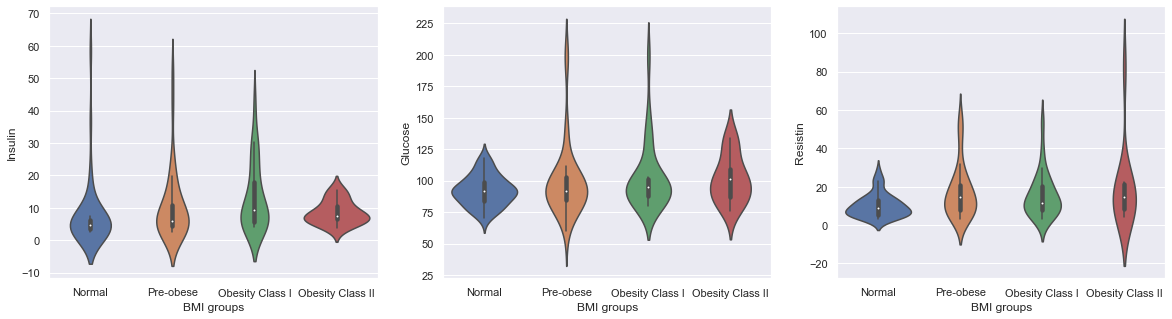

In [30]:
plt.figure(figsize = (20,5))

plt.subplot(1,3,1)
sb.violinplot(x='BMI groups', y='Insulin', data=stari_df)
plt.subplot(1,3,2)
sb.violinplot(x='BMI groups', y='Glucose', data=stari_df)
plt.subplot(1,3,3)
sb.violinplot(x='BMI groups', y='Resistin', data=stari_df)

In [31]:
pd.crosstab(stari_df['BMI groups'],stari_df['Classification']).style.background_gradient(cmap='summer_r')

Classification,0,1
BMI groups,,
Normal,17,23
Pre-obese,14,23
Obesity Class I,12,15
Obesity Class II,9,3


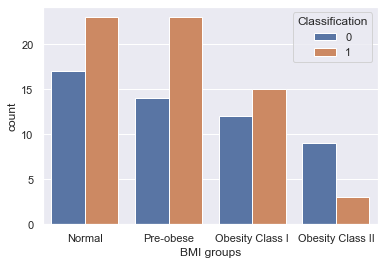

In [32]:
sb.countplot(x='BMI groups',hue='Classification',data=stari_df)

In [33]:
stari_df.drop(['BMI groups'], inplace = True, axis=1)

## 2. Klasifikacija

In [34]:
# nadgledano ucenje jer znamo unapred u koju grupu ispitanik spada (praktikum)
# klasifikacija kao podskup nadgledanog ucenja
# izlazna promenljive su oznake odredjenih kategorija
# rezultat obuke je model klasifikacije na osnovu koje bi se odredjivala klasna pripadnost

In [35]:
X = df.iloc[:, :-1] # u X smo stavili sva obelezja osim poslednje kolone
y = df.iloc[:, -1] # stavili smo poslednju kolonu

In [36]:
# podela podataka na skup za obuku i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10, stratify=y)

In [37]:
#rezultati.iloc[0:0]

In [38]:
#prikaz rezultata
rezultati = pd.DataFrame(columns = ['klasifikator', 'redukcija dimenzionalnosti', 'tacnost','specificnost', 'broj dimenzija'])

In [39]:
pca = PCA(n_components =0.99)
pca.fit(X_train)
X_pca = pca.transform(X_train)
X_pca = pca.transform(X_test)
print('Neredukovani prostor ima dimenziju: ', pca.n_components_)

Neredukovani prostor ima dimenziju:  8


In [40]:
def mere_uspesnosti(mat_konf):    
    TP = conf_mat[1, 1]
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    FN = conf_mat[1, 0]
    precision = TP/(TP+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    F_score = 2*precision*sensitivity/(precision+sensitivity)
    print('precision: ', precision)
    print('accuracy: ', accuracy)
    print('sensitivity/recall: ', sensitivity)
    print('specificity: ', specificity)
    print('F score: ', F_score)
    
    return {'acc': accuracy, 'spec': specificity}

### 2.1 Logisticka regresija

In [41]:
kf = StratifiedKFold(n_splits= 7, shuffle=True, random_state= 10)
indexes = kf.split(X, y)
fin_conf_mat = np.zeros((len(np.unique(y)),len(np.unique(y))))
for train_index, test_index in indexes:
    X_train1 = X.iloc[train_index,:]
    X_test1 = X.iloc[test_index,:]
    y_train1 = y.iloc[train_index]
    y_test1 = y.iloc[test_index]
    
    recall = []
    for num in [100, 200, 500, 1000]:
        for solv in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
            classifier = LogisticRegression(max_iter=num, solver=solv)
            classifier.fit(X_train1, y_train1)
            y_pred1 = classifier.predict(X_test1)  
            print('za parametre ', num, ' i ', solv, ' osetljivost je: ', recall_score(y_test1, y_pred1), 
                  ' a tacnost: ', accuracy_score(y_test1, y_pred1)) 
            recall.append(accuracy_score(y_test1, y_pred1))
    print('najbolja tacnost je u iteraciji broj: ', np.argmax(recall))
    
    classifier = LogisticRegression(max_iter=100, solver='newton-cg')
    classifier.fit(X_train1, y_train1)
    y_pred = classifier.predict(X_test1)
    conf_mat = confusion_matrix(y_test1, y_pred1)
    #print(conf_mat)
    fin_conf_mat += conf_mat
    
print('finalna matrica je: ')
print(fin_conf_mat)
mere_uspesnosti(fin_conf_mat)

za parametre  100  i  newton-cg  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  100  i  lbfgs  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  100  i  liblinear  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  100  i  sag  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  100  i  saga  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  200  i  newton-cg  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  200  i  lbfgs  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  200  i  liblinear  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  200  i  sag  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  200  i  saga  osetljivost je:  0.8888888888888888  a tacnost:  0.5882352941176471
za parametre  500  i

za parametre  1000  i  liblinear  osetljivost je:  0.6666666666666666  a tacnost:  0.5
za parametre  1000  i  sag  osetljivost je:  0.6666666666666666  a tacnost:  0.5
za parametre  1000  i  saga  osetljivost je:  0.6666666666666666  a tacnost:  0.5
najbolja tacnost je u iteraciji broj:  0
za parametre  100  i  newton-cg  osetljivost je:  0.7777777777777778  a tacnost:  0.5625
za parametre  100  i  lbfgs  osetljivost je:  0.7777777777777778  a tacnost:  0.5625
za parametre  100  i  liblinear  osetljivost je:  0.7777777777777778  a tacnost:  0.5625
za parametre  100  i  sag  osetljivost je:  0.7777777777777778  a tacnost:  0.5625
za parametre  100  i  saga  osetljivost je:  0.7777777777777778  a tacnost:  0.5625
za parametre  200  i  newton-cg  osetljivost je:  0.7777777777777778  a tacnost:  0.5625
za parametre  200  i  lbfgs  osetljivost je:  0.7777777777777778  a tacnost:  0.5625
za parametre  200  i  liblinear  osetljivost je:  0.7777777777777778  a tacnost:  0.5625
za parametre  20

{'acc': 0.75, 'spec': 0.7142857142857143}

[[4 1]
 [2 5]]
precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692

procenat sigurnosti u pogresnim:  0.5731800825426345
prosecno siguran u ispravnim:  0.6083577039022121

precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692
precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692


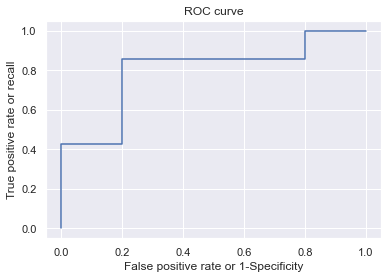

In [42]:
classifier = LogisticRegression(max_iter=100, solver='newton-cg')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate or 1-Specificity')
plt.ylabel('True positive rate or recall')
plt.title('ROC curve')

conf_mat = confusion_matrix(y_test, y_pred) 
print(conf_mat)
mere_uspesnosti(conf_mat)
wrong_predicted = (y_test != y_pred)
print('\nprocenat sigurnosti u pogresnim: ', classifier.predict_proba(X_test.loc[wrong_predicted,:]).max(axis=0).mean())
print('prosecno siguran u ispravnim: ', classifier.predict_proba(X_test.loc[~wrong_predicted,:]).max(axis=0).mean())
print()
data = {'klasifikator':'log reg', 'redukcija dimenzionalnosti': 'nema', 
        'tacnost': mere_uspesnosti(conf_mat)['acc'], 'specificnost':mere_uspesnosti(conf_mat)['spec'],
        'broj dimenzija':pca.n_components_}

rezultati = rezultati.append(data, ignore_index=True)

### 2.2 SVM

In [43]:
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=10)
indexes = kf.split(X, y)
fin_conf_mat = np.zeros((len(np.unique(y)),len(np.unique(y))))
acc = []
for c in [1, 10, 100]:
    for F in ['linear', 'rbf', 'poly']:
            acc_tmp = []
            for train_index, test_index in indexes:
                classifier = SVC(C=c, kernel=F)
                classifier.fit(X.iloc[train_index,:], y.iloc[train_index])
                y_pred = classifier.predict(X.iloc[test_index,:])
                acc_tmp.append(accuracy_score(y.iloc[test_index], y_pred))
                fin_conf_mat += confusion_matrix(y.iloc[test_index], y_pred) #, labels=labels_y
            print('za parametre C=', c, ', kernel=', F, ' tacnost je: ', np.mean(acc_tmp),
                  ' a mat. konf. je:')
            print(fin_conf_mat)
            acc.append(np.mean(acc_tmp))
print('najbolja tacnost je u iteraciji broj: ', np.argmax(acc))

za parametre C= 1 , kernel= linear  tacnost je:  0.6617647058823529  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
za parametre C= 1 , kernel= rbf  tacnost je:  nan  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
za parametre C= 1 , kernel= poly  tacnost je:  nan  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
za parametre C= 10 , kernel= linear  tacnost je:  nan  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
za parametre C= 10 , kernel= rbf  tacnost je:  nan  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
za parametre C= 10 , kernel= poly  tacnost je:  nan  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
za parametre C= 100 , kernel= linear  tacnost je:  nan  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
za parametre C= 100 , kernel= rbf  tacnost je:  nan  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
za parametre C= 100 , kernel= poly  tacnost je:  nan  a mat. konf. je:
[[33. 19.]
 [20. 44.]]
najbolja tacnost je u iteraciji broj:  1


D:\Apps\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Apps\Anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
classifier = SVC(C=1, kernel='linear')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
mere_uspesnosti(conf_mat)
print()
data = {'klasifikator':'SVM', 'redukcija dimenzionalnosti': 'nema', 
        'tacnost': mere_uspesnosti(conf_mat)['acc'], 'specificnost':mere_uspesnosti(conf_mat)['spec'],
        'broj dimenzija':pca.n_components_}

rezultati = rezultati.append(data, ignore_index=True)

[[4 1]
 [3 4]]
precision:  0.8
accuracy:  0.6666666666666666
sensitivity/recall:  0.5714285714285714
specificity:  0.8
F score:  0.6666666666666666

precision:  0.8
accuracy:  0.6666666666666666
sensitivity/recall:  0.5714285714285714
specificity:  0.8
F score:  0.6666666666666666
precision:  0.8
accuracy:  0.6666666666666666
sensitivity/recall:  0.5714285714285714
specificity:  0.8
F score:  0.6666666666666666


### 2.3 Neuronske mreze

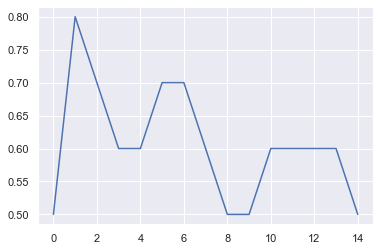

0.5294117647058824


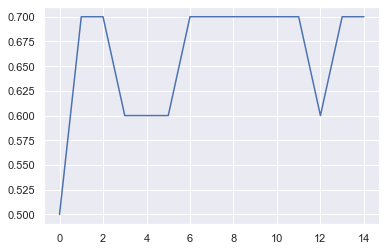

0.7058823529411765


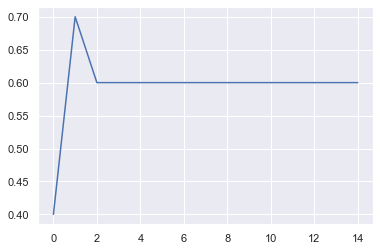

0.5882352941176471


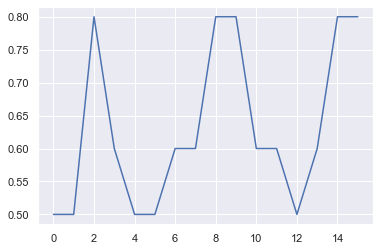

0.7058823529411765


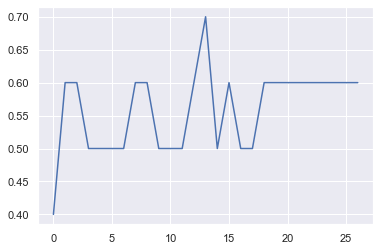

0.6875


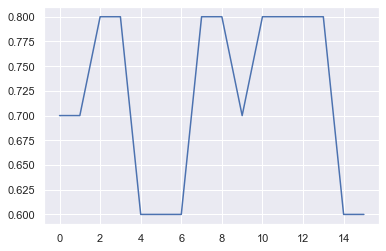

0.625


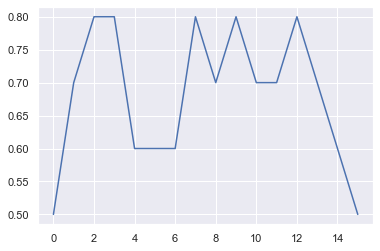

0.75
konacna matrica konfuzije: 
 [[16. 36.]
 [ 4. 60.]]
procenat tacno predvidjenih:  0.6551724137931034


In [45]:
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=10)
indexes = kf.split(X, y)
acc = []
fin_conf_mat = np.zeros((len(np.unique(y)),len(np.unique(y))))
for train_index, test_index in indexes:
    classifier = MLPClassifier(hidden_layer_sizes=(25,25,25), activation='tanh',
                              solver='adam', alpha = 0.00001,batch_size=40, learning_rate='adaptive', 
                              learning_rate_init=0.001, max_iter=60, shuffle=True,
                              random_state=10, early_stopping=True, n_iter_no_change=12,
                              validation_fraction=0.1, verbose=False)
    classifier.fit(X.iloc[train_index,:], y.iloc[train_index])
    y_pred = classifier.predict(X.iloc[test_index,:])
    #y_pred_p = classifier.predict_proba(X.iloc[test_index,:])
    plt.figure
    plt.plot(classifier.validation_scores_)
    #plt.plot(classifier.loss_curve_)
    plt.show()
    print(accuracy_score(y.iloc[test_index], y_pred))
    fin_conf_mat += confusion_matrix(y.iloc[test_index], y_pred)
print('konacna matrica konfuzije: \n', fin_conf_mat)
print('procenat tacno predvidjenih: ', sum(np.diag(fin_conf_mat))/sum(sum(fin_conf_mat)))

In [46]:
classifier = MLPClassifier(hidden_layer_sizes=(25,25,25), activation='tanh',
                              solver='adam', alpha = 0.00001,batch_size=40, learning_rate='adaptive', 
                              learning_rate_init=0.001, max_iter=60, shuffle=True,
                              random_state=10, early_stopping=True, n_iter_no_change=12,
                              validation_fraction=0.1, verbose=False)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
mere_uspesnosti(conf_mat)
print()
data = {'klasifikator':'NN', 'redukcija dimenzionalnosti': 'nema', 
        'tacnost': mere_uspesnosti(conf_mat)['acc'], 'specificnost':mere_uspesnosti(conf_mat)['spec'],
        'broj dimenzija':pca.n_components_}

rezultati = rezultati.append(data, ignore_index=True)

[[3 2]
 [2 5]]
precision:  0.7142857142857143
accuracy:  0.6666666666666666
sensitivity/recall:  0.7142857142857143
specificity:  0.6
F score:  0.7142857142857143

precision:  0.7142857142857143
accuracy:  0.6666666666666666
sensitivity/recall:  0.7142857142857143
specificity:  0.6
F score:  0.7142857142857143
precision:  0.7142857142857143
accuracy:  0.6666666666666666
sensitivity/recall:  0.7142857142857143
specificity:  0.6
F score:  0.7142857142857143


In [47]:
#tabelarni prikaz rezultata
rezultati.head(6)

,klasifikator,redukcija dimenzionalnosti,tacnost,specificnost,broj dimenzija
0,log reg,nema,0.75,0.80,8
1,SVM,nema,0.67,0.80,8
2,NN,nema,0.67,0.60,8


## 3. Redukcija dimenzionalnosti

### 3.1 PCA

In [48]:
s = StandardScaler()
X_std = s.fit_transform(X)

In [49]:
pca = PCA(n_components=2)
pca.fit(X_std)
X_pca = pca.transform(X_std)

Text(0.5, 1.0, 'PCA of MNIST dataset')

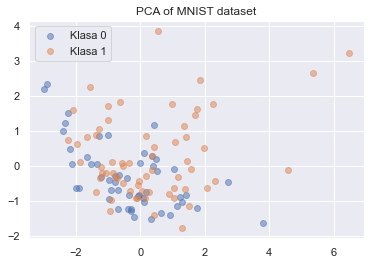

In [50]:
legenda = ['Klasa 0', 'Klasa 1']
plt.figure()
target_names = y.unique()
for i in target_names:
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], alpha=.5, label=i)
plt.legend(legenda)
plt.title('PCA of MNIST dataset')

In [51]:
#standardizacija
s = StandardScaler()
s.fit(X_train)
X_train_std = s.transform(X_train)
X_test_std = s.transform(X_test)

In [52]:
pca = PCA(n_components =0.9)
pca.fit(X_train_std)
X_pca = pca.transform(X_train_std)
X_pca = pca.transform(X_test_std)
print('Redukovani prostor ima dimenziju: ', pca.n_components_)

Redukovani prostor ima dimenziju:  6


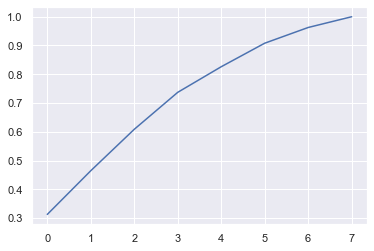

In [53]:
#zavisnost objašnjene varijanse od broja PCA komponenti
pca = PCA(n_components=None)
pca.fit(X_train_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

## 4. Klasifikacija nakon redukcije dimenzionalnosti

In [54]:
pca = PCA(n_components=0.9)
pca.fit(X_train_std)
X_train_r = pca.transform(X_train_std)
X_test_r = pca.transform(X_test_std)

### 4.1 Logisticka regresija

[[4 1]
 [2 5]]
precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692

precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692
precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692


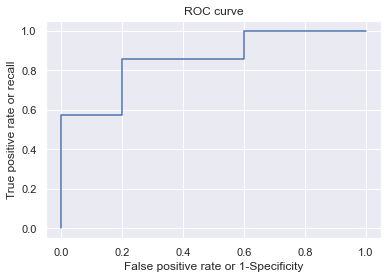

In [55]:
classifier = LogisticRegression(max_iter=100, solver='newton-cg')
classifier.fit(X_train_r, y_train)
y_pred = classifier.predict(X_test_r) 
y_pred_prob = classifier.predict_proba(X_test_r)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate or 1-Specificity')
plt.ylabel('True positive rate or recall')
plt.title('ROC curve')

conf_mat = confusion_matrix(y_test, y_pred) 
print(conf_mat)
mere_uspesnosti(conf_mat)
print()
data = {'klasifikator':'log reg', 'redukcija dimenzionalnosti': 'nema', 
        'tacnost': mere_uspesnosti(conf_mat)['acc'], 'specificnost':mere_uspesnosti(conf_mat)['spec'],
        'broj dimenzija':pca.n_components_}

rezultati = rezultati.append(data, ignore_index=True)

### 4.2 SVM

In [57]:
classifier = SVC(C=1, kernel='linear')
classifier.fit(X_train_r, y_train)
y_pred = classifier.predict(X_test_r)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
mere_uspesnosti(conf_mat)
print()
data = {'klasifikator':'SVM', 'redukcija dimenzionalnosti': 'nema', 
        'tacnost': mere_uspesnosti(conf_mat)['acc'], 'specificnost':mere_uspesnosti(conf_mat)['spec'],
        'broj dimenzija':pca.n_components_}

rezultati = rezultati.append(data, ignore_index=True)

[[4 1]
 [2 5]]
precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692

precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692
precision:  0.8333333333333334
accuracy:  0.75
sensitivity/recall:  0.7142857142857143
specificity:  0.8
F score:  0.7692307692307692


### 4.3 Neuronske mreze

In [58]:
classifier = MLPClassifier(hidden_layer_sizes=(25,25,25), activation='tanh', solver='adam', alpha = 0.00001,batch_size=40, 
                           learning_rate='adaptive', learning_rate_init=0.001, max_iter=60, shuffle=True, random_state=10, 
                           early_stopping=True, n_iter_no_change=12, validation_fraction=0.1, verbose=False)
classifier.fit(X_train_r, y_train)
y_pred = classifier.predict(X_test_r)
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
mere_uspesnosti(conf_mat)
print()
data = {'klasifikator':'NN', 'redukcija dimenzionalnosti': 'nema', 
        'tacnost': mere_uspesnosti(conf_mat)['acc'], 'specificnost':mere_uspesnosti(conf_mat)['spec'],
        'broj dimenzija':pca.n_components_}

rezultati = rezultati.append(data, ignore_index=True)

[[2 3]
 [2 5]]
precision:  0.625
accuracy:  0.5833333333333334
sensitivity/recall:  0.7142857142857143
specificity:  0.4
F score:  0.6666666666666666

precision:  0.625
accuracy:  0.5833333333333334
sensitivity/recall:  0.7142857142857143
specificity:  0.4
F score:  0.6666666666666666
precision:  0.625
accuracy:  0.5833333333333334
sensitivity/recall:  0.7142857142857143
specificity:  0.4
F score:  0.6666666666666666


In [59]:
#tabelarni prikaz rezultata
rezultati.head(6)

,klasifikator,redukcija dimenzionalnosti,tacnost,specificnost,broj dimenzija
0,log reg,nema,0.75,0.80,8
1,SVM,nema,0.67,0.80,8
2,NN,nema,0.67,0.60,8
3,log reg,nema,0.75,0.80,6
4,SVM,nema,0.67,0.80,6
5,SVM,nema,0.75,0.80,6


th:  [1.6111868  0.6111868  0.60228772 0.56145649 0.48110128 0.46616303
 0.41509632 0.39447139]
recall:  [0.         0.14285714 0.42857143 0.42857143 0.85714286 0.85714286
 1.         1.        ]
specificity:  [1.  1.  1.  0.8 0.8 0.2 0.2 0. ]

th:  [1.79418493 0.79418493 0.6859511  0.58017134 0.42535678 0.3252078
 0.28786398 0.14533941]
recall:  [0.         0.14285714 0.57142857 0.57142857 0.85714286 0.85714286
 1.         1.        ]
specificity:  [1.  1.  1.  0.8 0.8 0.4 0.4 0. ]



Text(0.5, 1.0, 'ROC curve')

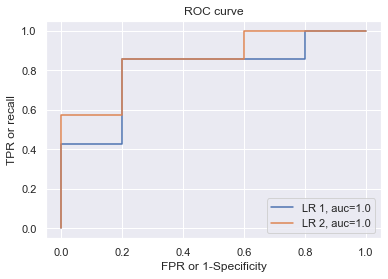

In [60]:
plt.figure(0).clf()

classifier = LogisticRegression(max_iter=100, solver='newton-cg')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_pred, y_pred_prob)
plt.plot(fpr, tpr,label="LR 1, auc="+str(auc))
print('th: ', threshold)
print('recall: ', tpr)
print('specificity: ', 1-fpr)
print()

classifier.fit(X_train_r, y_train)
y_pred2 = classifier.predict(X_test_r) 
y_pred_prob2 = classifier.predict_proba(X_test_r)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob2)
auc2 = roc_auc_score(y_pred2, y_pred_prob2)
plt.plot(fpr, tpr,label="LR 2, auc="+str(auc2))
print('th: ', threshold)
print('recall: ', tpr)
print('specificity: ', 1-fpr)
print()

plt.legend(loc=0)
plt.xlabel('FPR or 1-Specificity')
plt.ylabel('TPR or recall')
plt.title('ROC curve')